In [37]:
import numpy as np

# Helper Methods

In [981]:
def getUniqueColors(num):
  cm = plt.get_cmap('gist_rainbow')
  colors_norm = [cm(1.*i/num) for i in range(num)]
  return [(int(255 * r), int(255 * g), int(255 * b)) for r, g, b, _ in colors_norm]

# Load Model

In [1038]:
import pickle
import yaml
from sklearn import svm

model_path = "../models/large_window.sav"
config_path = "../models/large_window.yaml"

# load model
clf = pickle.load(open(model_path, 'rb'))
print(clf)

# load model configs
with open(config_path, "r") as stream:
  try:
    configs = yaml.safe_load(stream)
    dataset_configs = configs["dataset"]
    preprocessing_configs = configs["preprocessing"]
    svm_configs = configs["svm"]
    
    # Dataset parameters
    positive_negative_ratio = dataset_configs["positive_negative_ratio"]
    min_intersection_ratio = dataset_configs["min_intersection_ratio"]
    use_external_vehicle_samples = dataset_configs["use_external_vehicle_samples"]
    number_of_external_vehicle_samples = dataset_configs["number_of_external_vehicle_samples"]

    # Preprocessing parameters
    input_shape = (preprocessing_configs["input_shape"]["y"], preprocessing_configs["input_shape"]["x"])
    orientations = preprocessing_configs["orientations"] # number of orientation bins
    pixels_per_cell = (preprocessing_configs["pixels_per_cell"]["y"], preprocessing_configs["pixels_per_cell"]["x"]) # number of pixels per cell
    cells_per_block = (preprocessing_configs["cells_per_block"]["y"], preprocessing_configs["cells_per_block"]["x"]) # number of cells per block

    # SVM parameters
    C = svm_configs["C"]
    bagging = svm_configs["bagging"]
    n_estimators = svm_configs["n_estimators"]
    
    print(dataset_configs)
    print(preprocessing_configs)
    print(svm_configs)
  except yaml.YAMLError as exc:
    print(exc)

BaggingClassifier(base_estimator=SVC(C=3), n_estimators=50)
{'min_intersection_ratio': 0.8, 'number_of_external_vehicle_samples': 500, 'positive_negative_ratio': 1, 'use_external_vehicle_samples': True}
{'cells_per_block': {'x': 4, 'y': 4}, 'input_shape': {'x': 128, 'y': 80}, 'orientations': 9, 'pixels_per_cell': {'x': 16, 'y': 16}}
{'C': 3, 'bagging': True, 'n_estimators': 50}


## Load Test Images

../dataset/0001/000131.png
(1242, 375)


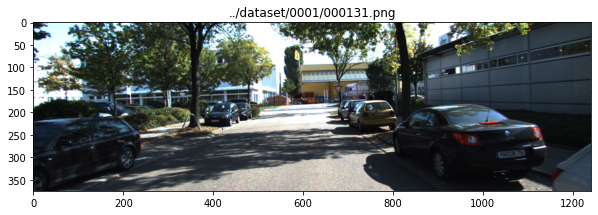

In [1039]:
import cv2
from random import randint
import matplotlib.pyplot as plt

seq_id = randint(0,3)
frame_id = randint(0,143)
# seq_id = 3
# frame_id = 38

img_path = f'../dataset/{seq_id:04d}/{frame_id:06d}.png'
print(img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_h, img_w, _ = img.shape
print((img_w, img_h))

# plot image
plt.figure(figsize=(10,10))
plt.title(img_path)
plt.imshow(img)

plt.show()

## Sliding Window

In [1040]:
def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False):

    """
    Run a sliding window across an input image and return a list of the
    coordinates of each window.
    Window travels the width of the image (in the +x direction) at a range of
    heights (toward the bottom of the image in the +y direction). At each
    successive y, the size of the window is increased by a factor equal to
    @param scale. The horizontal search area is limited by @param x_range
    and the vertical search area by @param y_range.
    @param image_size (int, int): Size of the image (width, height) in pixels.
    @param init_size (int, int): Initial size of of the window (width, height)
        in pixels at the initial y, given by @param y_range[0].
    @param x_overlap (float): Overlap between adjacent windows at a given y
        as a float in the interval [0, 1), where 0 represents no overlap
        and 1 represents 100% overlap.
    @param y_step (float): Distance between successive heights y as a
        fraction between (0, 1) of the total height of the image.
    @param x_range (float, float): (min, max) bounds of the horizontal search
        area as a fraction of the total width of the image.
    @param y_range (float, float) (min, max) bounds of the vertical search
        area as a fraction of the total height of the image.
    @param scale (float): Factor by which to scale up window size at each y.
    @return windows: List of tuples, where each tuple represents the
        coordinates of a window in the following order: (upper left corner
        x coord, upper left corner y coord, lower right corner x coord,
        lower right corner y coord).
    """

    windows = []
    y_count = 0
    h, w = image_size[1], image_size[0]
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        y_count += 1
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    if (dims):
        return windows, y_count
    return windows

146


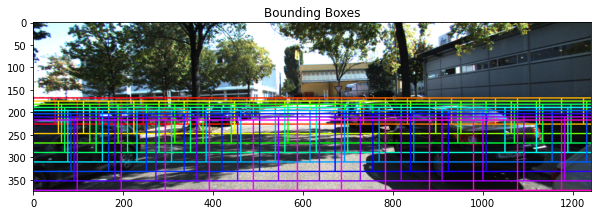

In [1041]:
# show windows 
img_windows = img.copy()

windows = slidingWindow((img_w, img_h),
                        init_size=(100,60), 
                        x_overlap=0.5, 
                        y_step=0.02, 
                        x_range=(0, 1), 
                        y_range=(0.45, 1), 
                        scale=2)

print(len(windows))
colors = getUniqueColors(len(windows))

for i, (xi, yi, xf, yf) in enumerate(windows): 
  img_windows = cv2.rectangle(img_windows, (xi, yi), (xf, yf), colors[i], 2)
  
# boxes
plt.figure(figsize = (10, 10)) 
plt.title("Bounding Boxes")
plt.imshow(img_windows)
plt.show()

# Predict

In [1042]:
from tools.preprocessing import *
  
feature_vectors = [
  preprocess_image(img[y_upper:y_lower, x_upper:x_lower, :], 
                  input_shape, orientations, 
                  pixels_per_cell, cells_per_block) 
  for (x_upper, y_upper, x_lower, y_lower) in windows
]

predictions = clf.predict(feature_vectors)

boxes = [windows[ind] for ind in np.argwhere(predictions == 1)[:,0]]

/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


## Show bounding boxes

percentage of positives: 0.03424657534246575


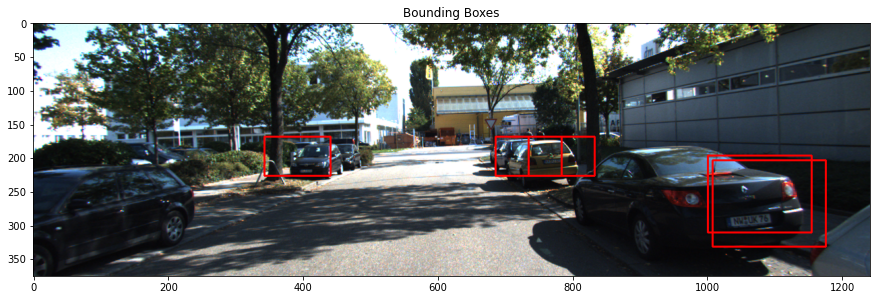

In [1043]:
img_boxes = img.copy()

colors = getUniqueColors(len(boxes))

for i, (xi, yi, xf, yf) in enumerate(boxes): 
  # img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), colors[i], 2)
  img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), (255, 0, 0), 2)
  
ratio_of_positives = len(boxes) / len(windows)
print(f"percentage of positives: {ratio_of_positives}")
  
# boxes
plt.figure(figsize = (15, 15)) 
plt.title("Bounding Boxes")
plt.imshow(img_boxes)
plt.show()

## Non-Maximum Suppression

In [1044]:
# https://towardsdatascience.com/non-maxima-suppression-139f7e00f0b5#:~:text=The%20Non%2Dmaximum%20suppression%20(NMS,contains%20a%20different%20bounding%20box.&text=The%20overlap%20treshold%20determines%20the,boxes%20are%20allowed%20to%20have.
def nonMaxSuppression(boxes, overlapThresh = 0.4):
  # if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

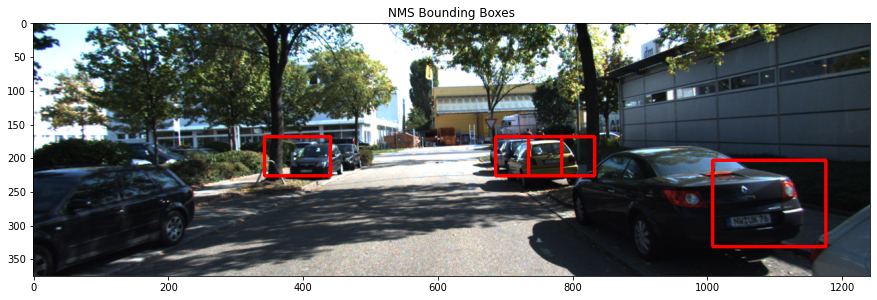

In [1051]:
from scipy.ndimage.measurements import label

overlapThresh = 0.5

nms_boxes = nonMaxSuppression(np.array(boxes), overlapThresh=overlapThresh)

img_boxes = img.copy()
for xi, yi, xf, yf in nms_boxes: 
  img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), (255, 0, 0), 4)
  
# boxes
plt.figure(figsize = (15, 15)) 
plt.title("NMS Bounding Boxes")
plt.imshow(img_boxes)
plt.show()

## Heat Map

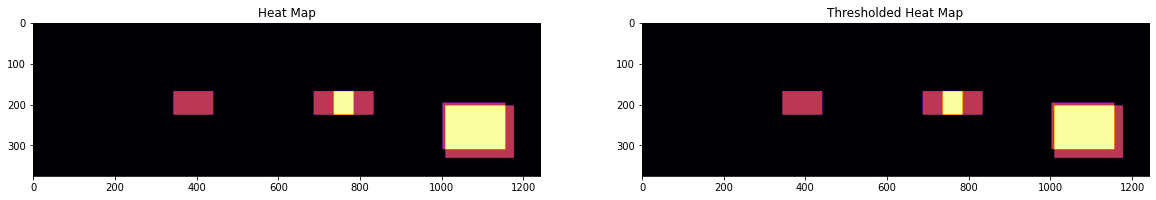

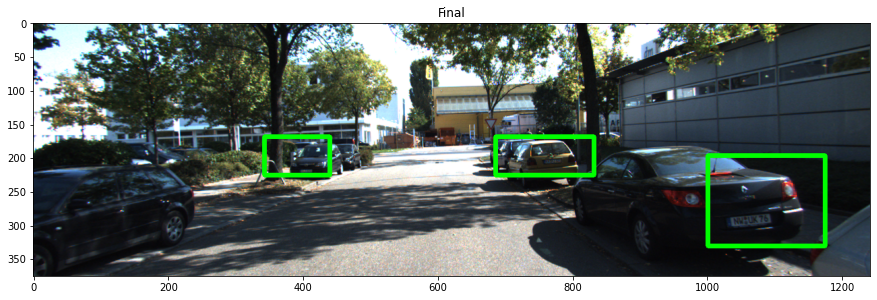

In [1046]:
from scipy.ndimage.measurements import label

threshold = 0
min_bbox = (50,50)

# https://nrsyed.com/2018/05/24/hog-based-svm-for-detecting-vehicles-in-a-video-part-6/
current_heatmap = np.zeros((img_h, img_w), dtype=np.float32)
for (xi, yi, xf, yf) in boxes:
    current_heatmap[yi:yf, xi:xf] += 1

# set treshold values to 0
threshold_heatmap = current_heatmap.copy()
threshold_heatmap[current_heatmap <= threshold] = 0

# label images
heatmap_labels = np.zeros((img_h, img_w))
num_objects = label(threshold_heatmap, output=heatmap_labels)

img_label = img.copy()

for obj in range(1, num_objects + 1):
  (Y_coords, X_coords) = np.nonzero(heatmap_labels == obj)
  x_upper, y_upper = min(X_coords), min(Y_coords)
  x_lower, y_lower = max(X_coords), max(Y_coords)

  # Only draw box if object is larger than min bbox size.
  if (x_lower - x_upper > min_bbox[0]
      and y_lower - y_upper > min_bbox[1]):
    cv2.rectangle(img_label, (x_upper, y_upper), (x_lower, y_lower), (0, 255, 0), 6)


# show heat map
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("Heat Map")
plt.imshow(current_heatmap, cmap="inferno")
plt.subplot(122)
plt.title("Thresholded Heat Map")
plt.imshow(threshold_heatmap, cmap="inferno")
plt.show()

# plot final
plt.figure(figsize = (15, 15)) 
plt.title("Final")
plt.imshow(img_label)
plt.show()      
